<h4><i><font color='red'>The project has many components, and we encourage you to complete as many as you can! That said, we highly encourage you to submit your work even if your notebook is only partially completed - the TA can help review your work and provide tips on any places that you got stuck or have further questions!</font></i></h4>

<font size="6">**Table of Contents:**</font>  
<font size="5">
1\. [Introduction](#scrollTo=alBGiNFLhU8M&uniqifier=1)  
2\. [Setup](#scrollTo=IpnucdoCui0M&uniqifier=1)  
3\. [Exploratory Data Analysis](#scrollTo=3QkLivc3fWvo&uniqifier=1)  
4\. [Simple Feature Preprocessing](#scrollTo=Bv75-bvqgPeg&uniqifier=1)  
5\. [The Key Metric for Candidate Generation: recall@k](#scrollTo=khvwUVsb_x0n&uniqifier=1)  
6\. [Candidate Generation Modeling](#scrollTo=vIDIfwgzhadf&uniqifier=1)</font>  
&emsp;&emsp;&emsp;<font size="4">a\. [Non-Learnt Models](#scrollTo=5Uqtg5rRmmOg&uniqifier=1)</font>  
&emsp;&emsp;&emsp;<font size="4">b\. [Two-Tower Model](#scrollTo=nijeGmCYgU0d&uniqifier=1)</font>  
<font size="5">7\. [TODO 1.1: Create Your Own Non-Learnt Candidate Generators
](#scrollTo=R7u5b2rucahG&uniqifier=1)  
8\. [TODO 1.2: Create Your Own Two-Tower CG (Optional)](#scrollTo=DZQjKKzOlPly&uniqifier=1)

# **1. Introduction**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

## Introduction to Multi-Stage Recommenders

Welcome to the week 1 project of the Personalized Recommendations at Scale course! In this week's project, we’ll look at one key component of a multi-stage recommender system -- the candidate generator.  
<br>
Candidate generation is when the recommendation system takes a large (millions) corpus of content and cuts it down to a small (hundreds or thousands) set of the most relevant items. The model for this stage optimizes for recall because if there’s an option the user might like we want it to be identified here.

The candidates generated in this phase are then passed to the ranking phase. In the ranking phase, the recommendations are ranked based on how appropriate they are for the user. This stage often involves feeding additional information to the system, like user history and content features. It might also incorporate other candidates' sources, such as new content or time-specific recommendations. The top-k items are then returned and used to populate the recommendation list.  
  
<br>A visualization of what this process looks like is shown below:  

![multi-stage system](https://miro.medium.com/max/1400/1*6LG9QN2XEtK6UCOZG4cavA.png)  
  
## This Week's Topic: Candidate Generation

As introduced above, when trying to recommend items to a user we typically start with a huge catalog of items! As a result our first step is to filter our millions of items into hundreds or thousands of the most relevant items evaluated by [recall as opposed to precision](https://en.wikipedia.org/wiki/Precision_and_recall#:~:text=Recall%20is%20the%20number%20of,documents%20retrieved%20by%20that%20search).  
  
The motivation for this is two-fold:  
1. **Total Latency**: A heavy ranker cannot deal with and rank tens of millions of items fast enough on its own. As such, candidate generators are often referred to as the "light ranker" and remove the need to rank most of the items in the corpus.
2. **Precision**: Filtering the item corpus down to a small set of the most relevant items can make the heavy ranker's job easier in terms of precision. Ranking the entire corpus, without a candidate generator as a first step, means the most relevant items are not gauranteed to be in the top several hundred or thousand as they would be had you used a candidate generator.
  
<br>  
## About the Data: [H&M's Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations) Personalized Fashion Recommendations

In this dataset we are given the purchase history of customers across time, along with supporting metadata.
* **articles.csv**: Detailed metadata for each article_id available for purchase.
* **customers.csv**: Metadata for each customer_id in dataset.
* **transactions_train.csv**: The training data consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item.  
  
<br>**This notebook benefits from using a GPU!**  
You can use it for free, in Google Colab, by going to the menu bar above, selecting `Runtime`, then `Change runtime type`, then selecting `GPU` as the `Hardware accelerator`.

# **2. Setup**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

In [1]:
# Installs and imports
!pip install -q --upgrade tensorflow-recommenders

import pandas as pd
import numpy as np
import tensorflow_recommenders as tfrs
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from typing import Dict, Text
import random
from collections import Counter
import gc
from tqdm import tqdm
from datetime import timedelta
from IPython.display import clear_output

# Download data
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies --folder https://drive.google.com/drive/folders/1j9QpkSKwqFfpgohbVxdPDKuwmwJXZ6yz?usp=sharing

clear_output()

In [2]:
# Read data into memory
article_df = pd.read_csv("hmdata/articles.csv.zip")
customer_df = pd.read_csv("hmdata/customers.csv.zip")
transaction_df = pd.read_csv('hmdata/transactions_train.csv.zip')

In [3]:
article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [4]:
customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [5]:
transaction_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


# **3. Exploratory Data Analysis (EDA)**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

In this section we'll take a dive into the data to understand it better.  
  
<br>We'll first look at the distribution of articles across index names:

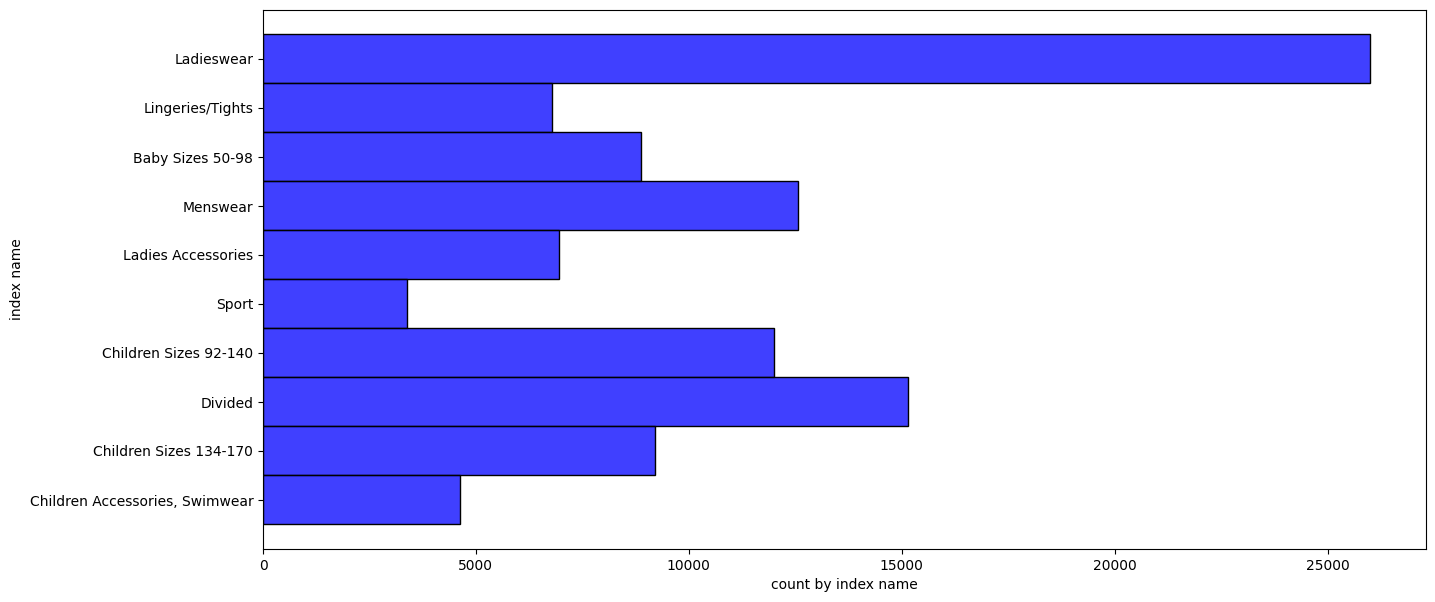

In [6]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_df, y='index_name', color='blue')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

We can see that "Ladieswear" is the largest index by a considerable margin, followed by "Divided".  
  
<br>Next let's look at the distribution of garment group names, with a further subdivision of index group name. This gives us an idea of how indices such as ladieswear are distributed within different garment groups.

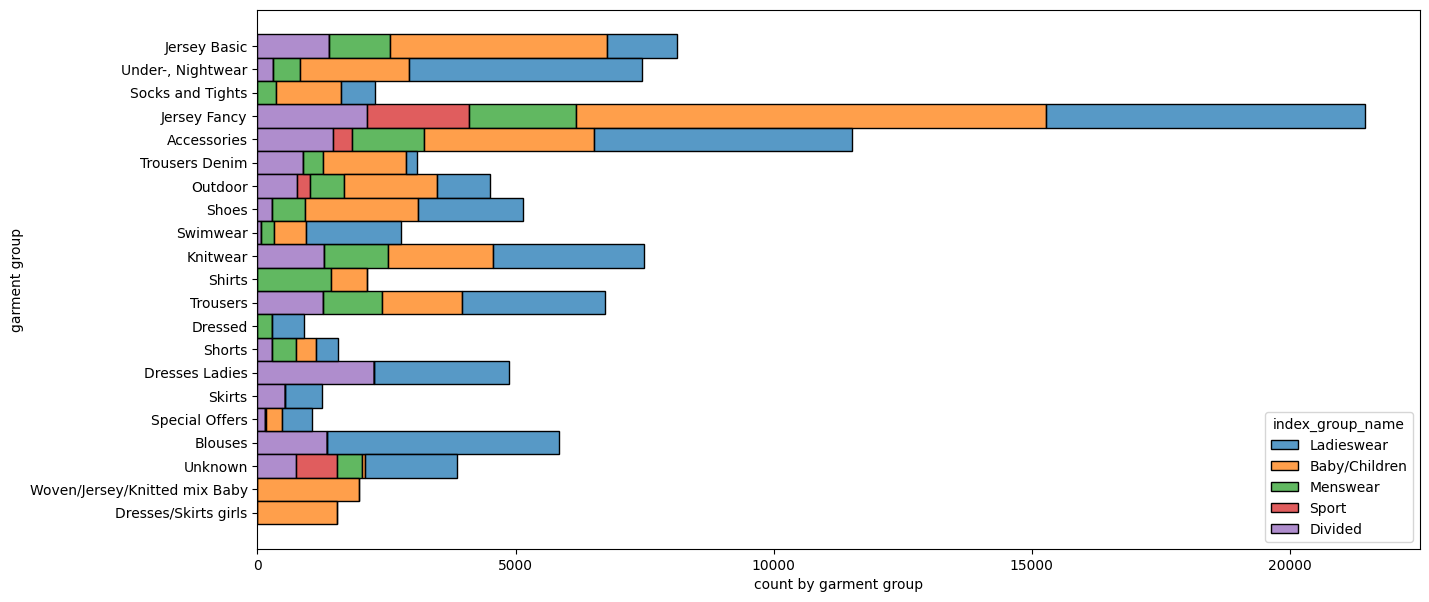

In [7]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_df, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

Next, let's look at the distribution of customer age:

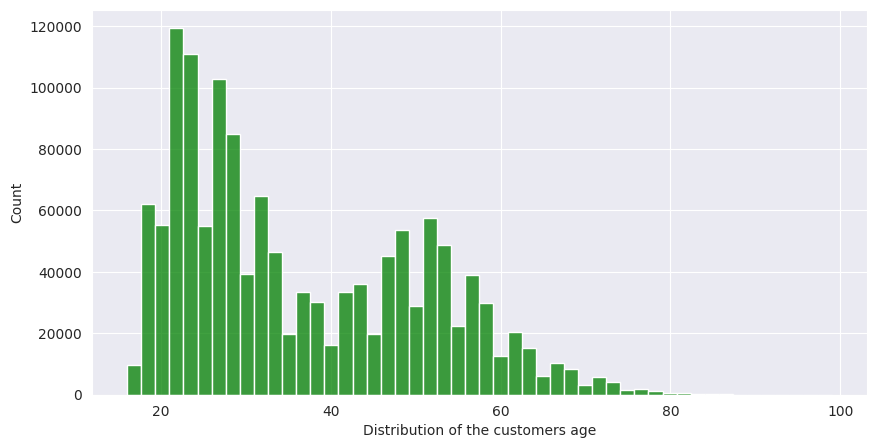

In [8]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customer_df, x='age', bins=50, color='green')
ax.set_xlabel('Distribution of the customers age')
plt.show()

From this plot we could argue there is bimodality present, with a large peak between the ages of 20-30 and a smaller peak at around 50 years old.  
  
<br>Let's now check for how prices are distributed across different product groups. It's worth noting that prices have been preprocessed to be between 0 and 1.

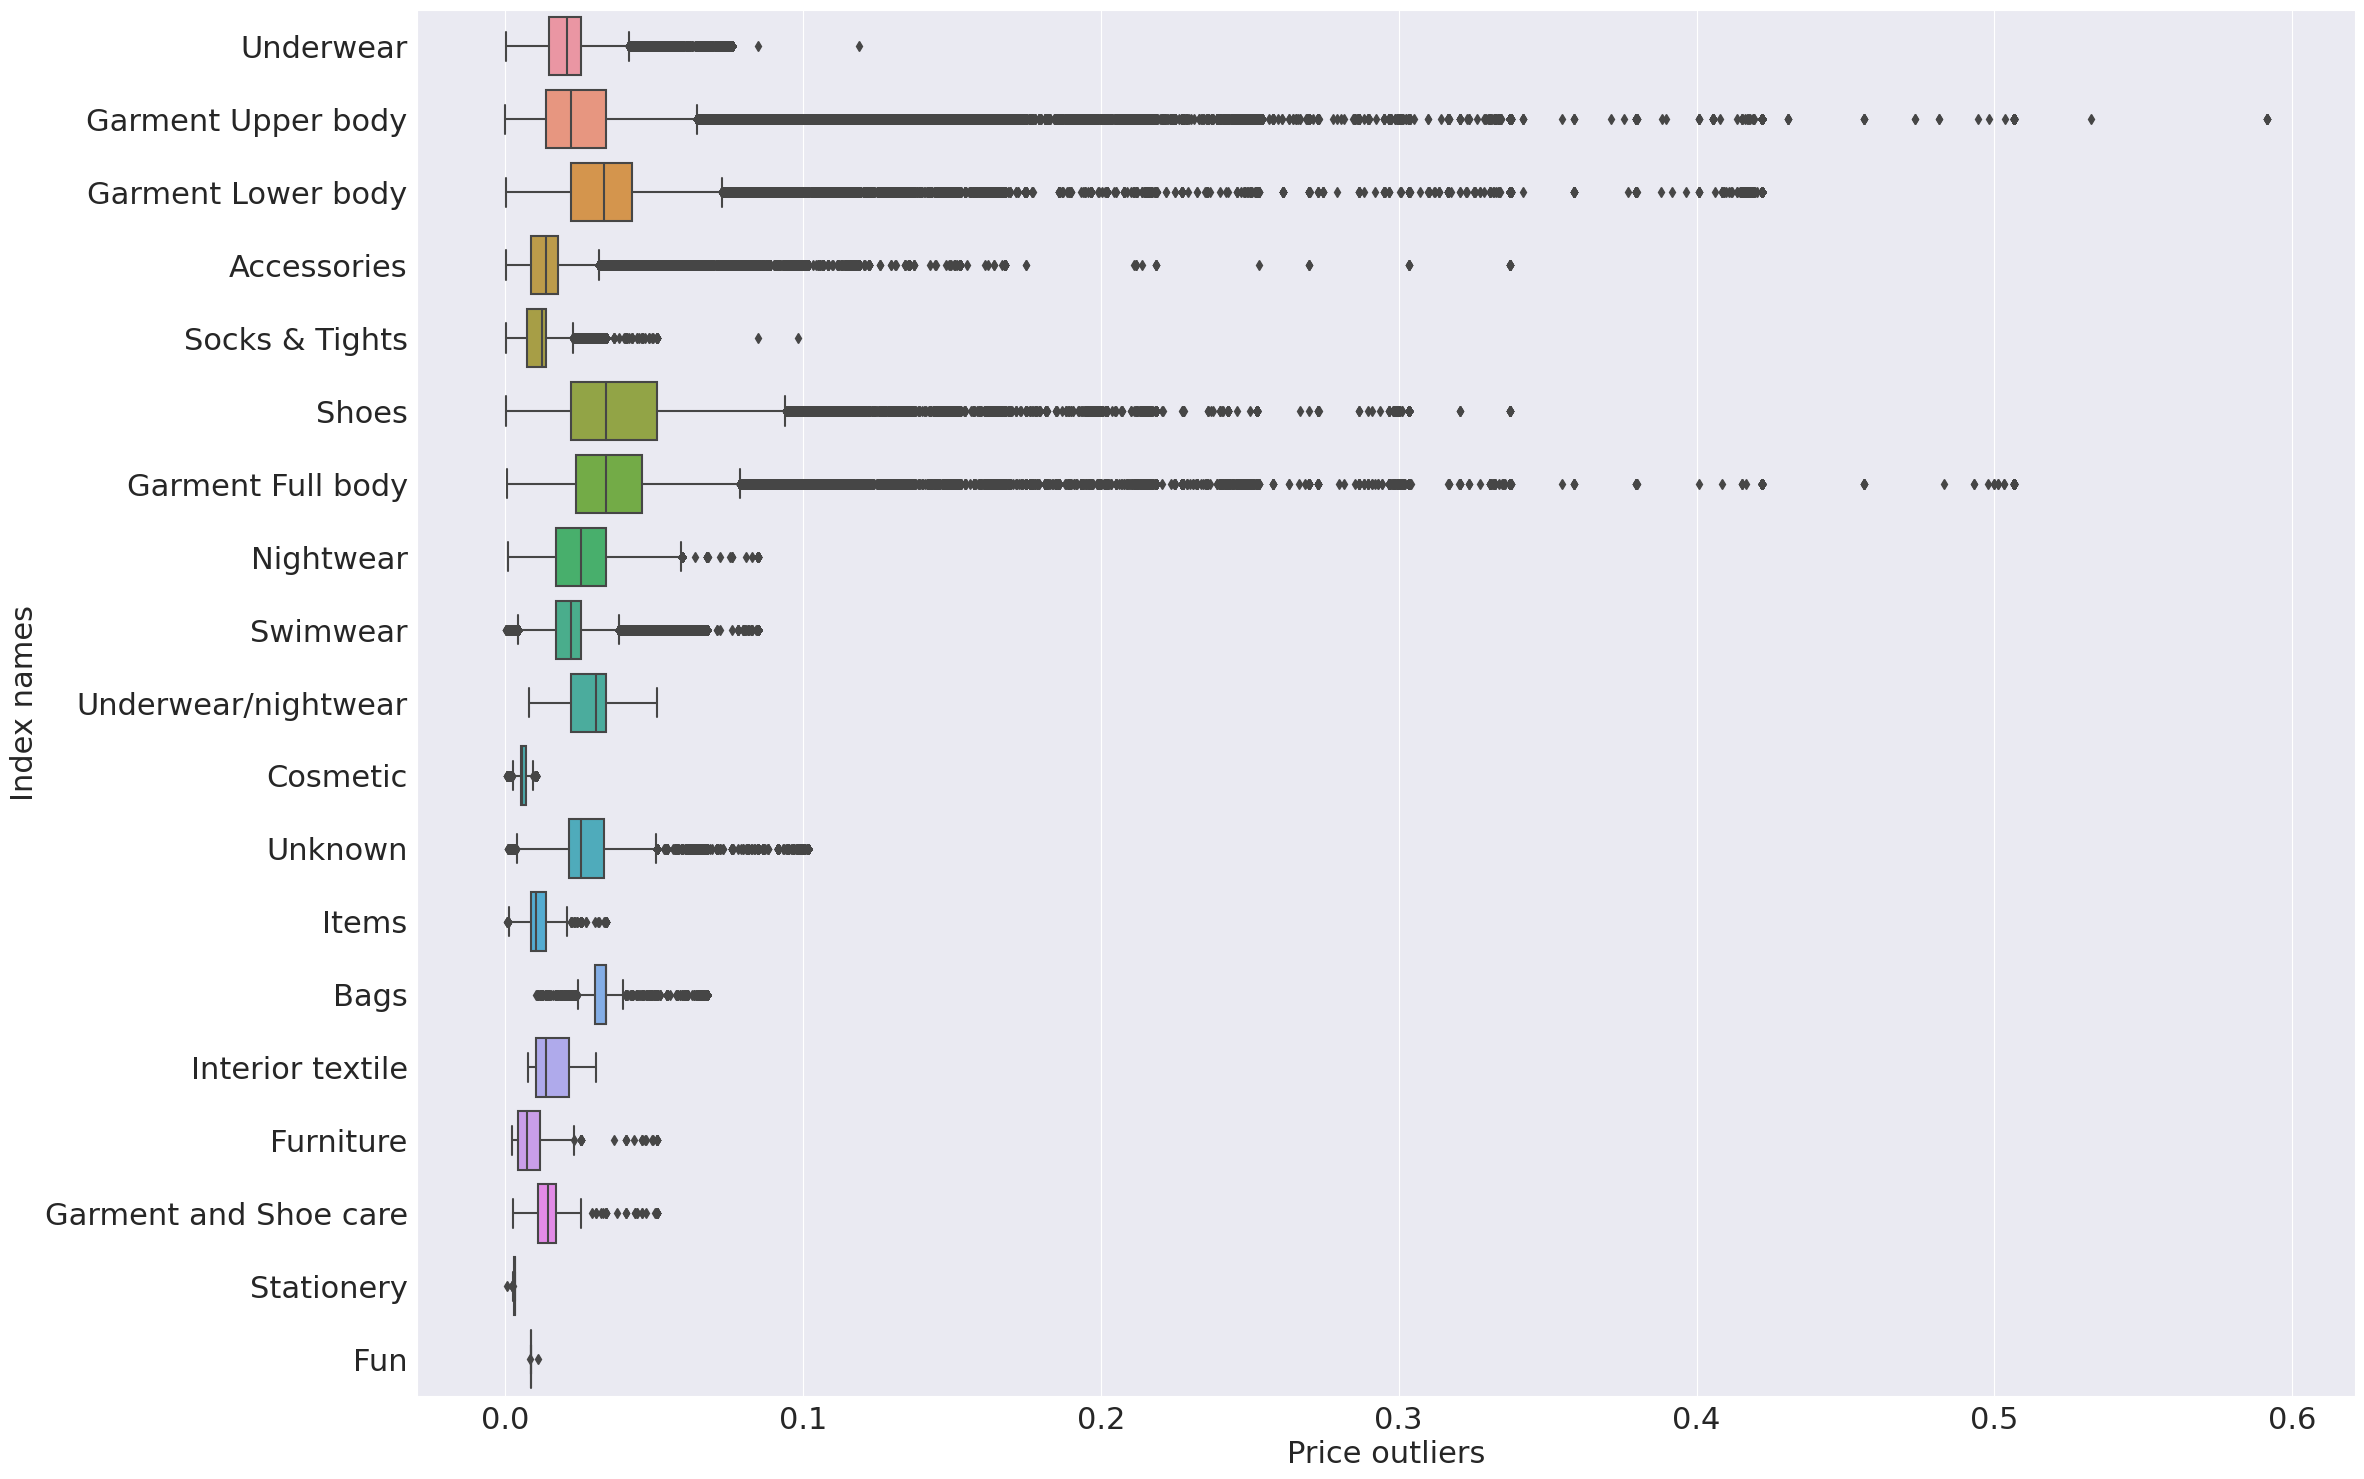

In [9]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(25,18))

# Merge transactions and articles so we relate price and product_group_name
ax = sns.boxplot(data=transaction_df[['article_id', 'price']].merge(article_df[['article_id', 'product_group_name']], on='article_id', how='left'),
                 x='price', y='product_group_name')

ax.set_xlabel('Price outliers', fontsize=22)
ax.set_ylabel('Index names', fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
plt.show()

From this plot we can infer that while shoes may have a comparatively high median price it has less extreme price outliers than some more expensive upper body or full body garments.

# **4. Simple Feature Processing**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

In this section we'll lightly process the features so we can more easily model them.  
  
<br>We'll start with customer data:

In [10]:
# Impute missing data
customer_df["FN"].fillna(0, inplace=True)
customer_df["Active"].fillna(0, inplace=True)
customer_df["club_member_status"].fillna("UNKNOWN", inplace=True)
customer_df["fashion_news_frequency"] = customer_df["fashion_news_frequency"].replace({"None":"NONE"})
customer_df["fashion_news_frequency"].fillna("UNKNOWN", inplace=True)
customer_df["age"].fillna(customer_df["age"].median(), inplace=True)

# Bucket age groups
def create_age_interval(x):
    if x <= 25:
        return [16, 25]
    elif x <= 35:
        return [26, 35]
    elif x <= 45:
        return [36, 45]
    elif x <= 55:
        return [46, 55]
    elif x <= 65:
        return [56, 65]
    else:
        return [66, 99]
customer_df["age_interval"] = customer_df["age"].apply(lambda x: create_age_interval(x))

# Make sure all nulls are filled in customer_df
assert customer_df.isnull().sum().sum() == 0

customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_interval
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[46, 55]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[16, 25]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[16, 25]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"[46, 55]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[46, 55]"


Now we'll process article data:

In [11]:
# Impute missing data
article_df.fillna(value="No Description", inplace=True)

# Change article_id datatype to string
article_df['article_id'] = article_df['article_id'].astype(str)

# Add a zero to the left of the article_id string
article_df['article_id'] = article_df['article_id'].apply(lambda x: x.zfill(10))

article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


And finally we'll apply the same transformation from articles above to the corresponding article_ids in the transactions dataset:

In [12]:
transaction_df['article_id'] = transaction_df['article_id'].astype(str)
transaction_df['article_id'] = transaction_df['article_id'].apply(lambda x: x.zfill(10))

transaction_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


# **5. The Key Metric for Candidate Generation: recall@k**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

The goal of the candidate generator is to fetch enough relevant candidates for the ranker to rank.If the candidate generator does this well, the ranker can do a better job at ranking these candidates. However, if the candidate generator misses out on a large set of relevant items, the ranker cannot rank them since it doesn't have access to good candidate items.

Given such a role of the candidate generator, recall becomes the key metric with which we evaluate different candidate generators. _Recall@k_ is the proportion of relevant items found in the top-k selected candidates.
  
<br>Mathematically, it's defined as follows:  
_Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)_
  
<br>For example, suppose we have a user who will make 5 purchases next month and we wish to make 10 recommendations to this user on the homepage from among the set of 1 million products. Further suppose we have two candidate generators (CG-A and CG-B), each returning 100 candidates that the ranker can consume and select the top 10 recommendations. If CG-A is able to retrieve 3 of these 5 products amongst its set of 100 candidates, and CG-B is able to retrieve only 2 of the 5 products amongst its set of 100 candidates, then CG-A would have a higher recall than CG-B.
Recall for CG-A = 3/5
Recall for CG-B = 2/5
  
<br>Let's implement this recall metric in a simple function and try it out.

In [13]:
# Intersection helper function
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
def estimate_recall(cg, purchase):
    return len(intersection(cg,purchase))/len(purchase)


# Test the functions with toy example.
# How many items from purchases did each CG retrieve?
purchases = ["item45","item97","item71","item125","item5"]
cg1 = ["item1","item97","item12","item105","item5","item17","item197","item122","item85","item15"]
cg2 = ["item13","item94","item14","item15","item5","item18","item197","item132","item86","item65"]

print("recall for CG1: ", estimate_recall(cg1, purchases))
print("recall for CG1: ", estimate_recall(cg2, purchases))

recall for CG1:  0.4
recall for CG1:  0.2


# **6. Candidate Generation Modeling**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

Now that we can evaluate a candidate generator, let's take a look at a few! We'll start with non-learnt candidate generators, which are have no loss function/objective to optimize for.
  
> **1. Candidate Generator 1: Random products**  
The simplest candidate generator to start with is a random candidate selector -- from amongst the list of products, randomly select products.


> **2. Candidate Generator 2: Most popular products**  
Another simple candidate selection strategy is to select the top-k most popular products from historic interactions and use this list as the set of candidates for the downstream ranking goal.
  
<br>In order to have a clean evaluation set-up, we will divide the transactions data into train and test split. We use the last week of transactions as the test set (as was done in the [original competition](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview/evaluation)) and the preceding 6 weeks as the training set (as was done in the [1st place submission](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/324070)). Feel free to change these values.  
  
<br>Below we will implement these two candidate generators and compare their recall performace:

In [14]:
# Split transactions into train and test
N_DAYS_TRAIN = 45
N_DAYS_TEST = 7

max_date = transaction_df['t_dat'].max()
train = transaction_df[(transaction_df['t_dat']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TRAIN+N_DAYS_TEST)).date().strftime('%Y-%m-%d')))
                        & (transaction_df['t_dat']<((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]
test = transaction_df[(transaction_df['t_dat']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]


# Delete transaction_df from the namespace to free up some memory
transaction_df = None
del transaction_df
gc.collect()

train.shape, test.shape

((1769097, 5), (266364, 5))

For ease of evaluation, without any loss of generalization, we only consider customers that have made a purchase in both train and test time-periods. We'll label them `common_users`. The methods and set-up remain the same for all other customers as well.

In [15]:
c1 = train['customer_id'].to_list()
c2 = test['customer_id'].to_list()

# Note: Sorting common_users so evaluation is deterministic
common_users = sorted(intersection(c1, c2))

print(len(train), len(test), len(c1), len(c2), len(common_users))

1769097 266364 1769097 266364 42395


## **6a. Non-Learnt Models**
[back to top](#scrollTo=M2t2RSi5gOuE&line=2&uniqifier=1)

Candidate Generator 1: Random products

In [16]:
# Pre-calculate unique items so they can be re-used during every invocation
train_unique_items = sorted(train['article_id'].unique().tolist())

def get_k_candidates_random(u, k):
    """
    Generate k random candidates from the training set.

    Args:
        u (str): user ID for which to generate the candidates.
        k (int): Number of candidates to generate.

    Returns:
        candidates (list): Random k candidates.
    """

    # Set the seed to the user ID to make this function deterministic
    random.seed(u)
    candidates = random.sample(train_unique_items, k)
    return candidates

Candidate Generator 2: Most popular products

In [17]:
# Pre-calculate item counts so they can be re-used during every invocation
train_item_counts = Counter(train['article_id'].to_list()).most_common()

def get_top_k_candidates_popular(u, k):
    """
    Generate k most popular (number of times purchased) candidates from the training set.

    Args:
        u (str): user ID for which to generate the candidates. Not necessary for this function, but is an assumed input during evaluation.
        k (int): Number of candidates to generate.

    Returns:
        candidates (list): The most popular k candidates.
    """
    candidates = [article for article, count in train_item_counts[:k]]
    return candidates

Below we implement a function to assess the recall of our candidate generators. For speed of computation we test with only 100 users but feel free to increase this as your time and RAM allow.

In [18]:
def run_candidate_generation(method, k_values=[100,1000], user_set_size=100):
    """
    Evaluate a given candidate generator in terms of recall on the held-out test set.

    Args:
        method (function): Candidate generation function. User ID (u) and number of candidates (k) arguments.
        k_values (list): List of number of candidates to generate and evaluate.
        user_set_size (int): Number of users to evaluate.

    Returns:
        None. Prints results.
    """

    # Initialise evaluation variables
    k_values = sorted(k_values)
    recall_dict = {k:0 for k in k_values}
    user_set = common_users[:user_set_size]

    # Loop over users
    for u in tqdm(user_set):
        # Get list of purchased items for user u
        purchase_list = test[test['customer_id']==u]['article_id'].to_list()
        # Run candidate generation
        cg = method(u, max(k_values))
        for k in k_values:
            # Estimate recall for candidate generator
            recall = estimate_recall(cg[:k], purchase_list)
            # Add this to overall recall (to be averaged at end)
            recall_dict[k] += recall

    print(f"\nRecall evaluation for {user_set_size:,} users:")
    for k in k_values:
        # Average recall by dividing sum of recalls by user_set length
        overall_recall = recall_dict[k] / len(user_set)
        print(f"Recall @ {k} Candidates: {overall_recall:.5f}")

In [19]:
# Evaluate CG 1 (random)
run_candidate_generation(get_k_candidates_random)

100%|██████████| 100/100 [00:02<00:00, 44.04it/s]


Recall evaluation for 100 users:
Recall @ 100 Candidates: 0.00259
Recall @ 1000 Candidates: 0.01515


In [20]:
# Evaluate CG 2 (popularity)
run_candidate_generation(get_top_k_candidates_popular)

100%|██████████| 100/100 [00:02<00:00, 45.95it/s]


Recall evaluation for 100 users:
Recall @ 100 Candidates: 0.09398
Recall @ 1000 Candidates: 0.31827


We notice that the recall@k metric is significantly higher for the popular CG than for the random CG, which is in line with our expectations.

Both of these CGs are non-learnt and generic across all users. We'll now discuss a learnt CG model -- the two-tower model which we covered in lecture.

## **6b. Two-Tower Model**
[back to top](#scrollTo=M2t2RSi5gOuE&line=2&uniqifier=1)

The [two tower model](https://corise.com/course/personalized-recommendation-at-scale/v2/module/modern-recommender-systems) is a neural network that is made up of two separate sub-models, one that learns representations for the users, and one that learns representations for candidates or items. These representations are then multiplied in a dot product to produce a prediction of whether a user will like an item. This is currently one of the best-performing models for candidate generation, as it learns information from both users and items. Below you can see a visualization of how this process works:  
  
> **3. Candidate Generator 3: Two-tower model**  
One of most popular, and industry-wide used CGs is a two-tower neural network. This is a learnt deep model with one tower for the user and another tower for the product, followed by a dot product.

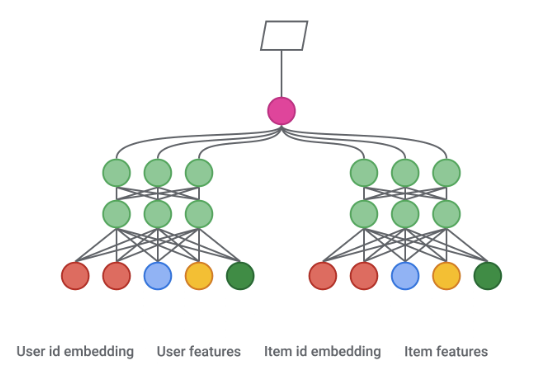  
  
<br>This approach is useful for candidate generation across a wide variety of industries, from online retail to social media! With one tower representing the users and the other representing the items, the system can learn a lot about whether a user might like a particular item. These models are trained using implicit signals – YouTube, for example, might consider how many seconds a user streamed a video, or how they interacted with it. The learned information can then be combined to produce the final prediction.  
  
<br>First we will generate a list of unique customer and article ids which we will use to create our vocabulary for our [StringLookup layer](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/) which offers a really convenient way for us to pass a vocabulary to an [Embedding layer](https://keras.io/api/layers/core_layers/embedding/).

In [21]:
# Create lists of unique ids
unique_customer_ids = train.customer_id.unique()
unique_article_ids = train.article_id.unique()

We now generate our customer model (the customer tower) and the article model (the article tower). Feel free to play around with the size of the embedding dimension and the architecture!

In [22]:
embedding_dimension = 64

tf.keras.utils.set_random_seed(42)

customer_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_customer_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_customer_ids) + 1, embedding_dimension),
  tf.keras.layers.Dense(64, activation='relu')
])

article_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_article_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_article_ids) + 1, embedding_dimension),
  tf.keras.layers.Dense(64, activation='relu')
])

We will convert our pandas dataframes into [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) as they are easier to use with Keras.


In [23]:
article_ds = tf.data.Dataset.from_tensor_slices(dict(article_df[['article_id']]))
articles = article_ds.map(lambda x: x['article_id'])

Now we can formally place our `customer_model` and `article_model` towers into a trainable class, which Tensorflow Recommenders expects. We'll be inheriting from `tfrs.Model` and using the special [tfrs.tasks.Retrieval](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/tasks/Retrieval) task, which allow us to abstract away much of the boilerplate in training this model.
  
<br>If you want to know more you can visit this [example](https://www.tensorflow.org/recommenders/examples/basic_retrieval) and the associated documentation. We'll be using the [tfrs.metrics.FactorizedTopK](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/metrics/FactorizedTopK) metric to monitor model training, which calculates how often the true candidate is in the top K candidates for a given query. Note that this is quite computationally expensive to run as, by default, this metric will use every other article besides the "true" purchased article and run it through the article model. For this reason we only calculate this metric when evaluating the model.

In [24]:
class HandMModel(tfrs.Model):

    def __init__(self, customer_model, article_model):
        super().__init__()
        self.article_model: tf.keras.Model = article_model
        self.customer_model: tf.keras.Model = customer_model
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
            candidates=articles.batch(128).map(self.article_model), # Batching articles into size 128 and passing through the article model
            ),
        )

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:

        customer_embeddings = self.customer_model(features["customer_id"])
        article_embeddings = self.article_model(features["article_id"])

        # The task computes the loss and the metrics.
        # Note that by default compute_metrics is set to not_training as running during training is VERY expensive
        return self.task(customer_embeddings, article_embeddings, compute_metrics=not training)

After defining the model, we can use standard Keras fitting and evaluation routines.

Let's first instantiate the model:

In [25]:
# Instantiate model
model = HandMModel(customer_model, article_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

Then let's shuffle, batch, and cache the train and test split, and then train the model on the training data.

In [26]:
# The `from_tensor_slices` method creates a dataset with a separate element for each row of the input tensor
# Shuffling randomly shuffles the dataset and batching sets the batch size to 256
# Caching keeps the dataset in memory (or a specified file). For larger datasets sometimes we cannot fit the entire dataset in memory and thus use a file on disk.
train_ds = tf.data.Dataset.from_tensor_slices(dict(train[['customer_id','article_id']])).shuffle(100_000, seed=42).batch(256).cache()


# Fit the model
# FactorizedTopK will show as 0, but these are the expensive metrics and as training=True they will not be calculated
num_epochs = 4
history = model.fit(train_ds, epochs=num_epochs, verbose=1)

Epoch 1/4
6911/6911 [==============================] - 28s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1274.3479 - regularization_loss: 0.0000e+00 - total_loss: 1274.3479
Epoch 2/4
6911/6911 [==============================] - 25s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 958.1542 - regularization_loss: 0.0000e+00 - total_loss: 958.1542
Epoch 3/4
6911/6911 [==============================] - 25s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 

As the model trains we see the `total_loss` fall, as expected.  
  
<br>Finally, we can evaluate our model on the test set by calculating `FactorizedTopK`. This tell us whether a true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

In [27]:
# Take a sample of 2000 elements from the test set and run inference on them
test_ds = tf.data.Dataset.from_tensor_slices(dict(test.sample(2000, random_state=42)[['customer_id','article_id']])).batch(500).cache()

# We now see the metrics are not in fact zero (train=False here, so they are computed)
model.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 8s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0035 - factorized_top_k/top_5_categorical_accuracy: 0.0105 - factorized_top_k/top_10_categorical_accuracy: 0.0160 - factorized_top_k/top_50_categorical_accuracy: 0.0295 - factorized_top_k/top_100_categorical_accuracy: 0.0400 - loss: 3829.1976 - regularization_loss: 0.0000e+00 - total_loss: 3829.1976


{'factorized_top_k/top_1_categorical_accuracy': 0.0035000001080334187,
 'factorized_top_k/top_5_categorical_accuracy': 0.010499999858438969,
 'factorized_top_k/top_10_categorical_accuracy': 0.01600000075995922,
 'factorized_top_k/top_50_categorical_accuracy': 0.029500000178813934,
 'factorized_top_k/top_100_categorical_accuracy': 0.03999999910593033,
 'loss': 3846.44140625,
 'regularization_loss': 0,
 'total_loss': 3846.44140625}

Now that we have a model, we would like to be able to efficiently make predictions. We can use the [tfrs.layers.factorized_top_k.BruteForce](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/layers/factorized_top_k/BruteForce) layer to do this, which will store article representations and efficiently perform a, exhaustive dot product on them and the query, user representation to generate the top k candidates.  
  

<br>As we will now demonstrate, the embeddings from the pen-ultimate layer of these models are typically stored for real-time retrieval. Indeed, these embeddings represent the user and items in a shared embedding space and can be consumed by various models powering downstream tasks. To store embeddings for 400 million users and over 100 million items and querying them in real time is a challenging task. This is where approximate nearest neighbor approaches step in to help. In the week 3 project, we will briefly try a few such approximate nearest neighbor approaches when dealing with user representations.

In [28]:
# Create an index that takes in raw customer features, and recommends articles out of the entire dataset
index = tfrs.layers.factorized_top_k.BruteForce(model.customer_model)
index.index_from_dataset(
  tf.data.Dataset.zip((articles.batch(1000), articles.batch(1000).map(model.article_model)))
)

# Get recommendations for a given example customer
_, candidates = index(tf.constant(["00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657"]), k=50)
print(f"Recommendations for customer: {candidates}")

Recommendations for customer: [[b'0568601043' b'0810591002' b'0664074039' b'0858856005' b'0854247001'
  b'0872378001' b'0664074059' b'0826508007' b'0770315010' b'0664074030'
  b'0395127012' b'0664074007' b'0847673005' b'0770315015' b'0751471034'
  b'0912075007' b'0663396001' b'0716670009' b'0809411003' b'0770315009'
  b'0770315026' b'0770315005' b'0816845001' b'0708138037' b'0915611001'
  b'0664074078' b'0889460002' b'0770315020' b'0872393002' b'0842605012'
  b'0728156018' b'0766346011' b'0762856007' b'0568601030' b'0664074079'
  b'0568601026' b'0695632001' b'0770315008' b'0708138025' b'0770315007'
  b'0781758057' b'0784001006' b'0716670007' b'0818030002' b'0724773004'
  b'0762796007' b'0695632002' b'0770315014' b'0843457002' b'0728156001']]


Similar to the CG1 and CG2 functions, we'll define the two-tower CG function that takes in a customer ID and value k, and returns the list of top-k candidate products:

In [29]:
def get_top_k_candidates_2_tower(u, k):
    """
    Generate k candidates from the training set using the two-tower model.

    Args:
        u (str): user ID for which to generate the candidates.
        k (int): Number of candidates to generate.

    Returns:
        candidates (list): The top-k candidates.
    """
    _, candidates = index(tf.constant([u]), k=k)
    candidates = candidates.numpy().flatten()
    candidates = [c.decode("utf-8") for c in candidates]
    return candidates

We can now use the evaluation function to estimate the recall metric for this new CG, and compare with the other 2 CGs we implemented above.

In [30]:
run_candidate_generation(get_top_k_candidates_2_tower)

100%|██████████| 100/100 [00:03<00:00, 32.10it/s]


Recall evaluation for 100 users:
Recall @ 100 Candidates: 0.10321
Recall @ 1000 Candidates: 0.23227


Now let's compile the results from the three different Candidate Generators we implemented:  
<i>Note: Due to randomness in Keras' processes, your results from the two-tower CG will likely differ.</i>
  
<br>  **Recall @ 100, for 100 users**
- CG1: Random 0.00
- CG2: Popular 0.09
- CG3: Two-tower 0.10 (may vary)

**Recall @ 1000, for 100 users**
- CG1: Random 0.02
- CG2: Popular 0.32
- CG3: Two-tower 0.21 (may vary)
  
<br>We notice that the random CG performs the worst, and, with just 4 epochs of training, the two-tower CG is able to achieve a good recall score. For this set of 100 users, the popularity based CG outperforms the learnt, Two-Tower CG at 1,000 candidates. In practice, popularity is generally a strong CG method and so a more full evaluation would be necessary to properly compare these generators. Remember that we've only used ID variables and, ultimately, our goal may very well be to combine several candidate generators in an effort to create high-performing, diverse sets of candidates.

# **7. TODO 1.1: Create Your Own Non-Learnt Candidate Generators**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

In this section you'll implement two personalized, non-learnt candidate generators:

1.   Personalized to users' interest
2.   Personalized to users' price sensitivity

Once implemented, evaluate them and compare the recall@k to that of the 3 CGs we implemented above.



In [31]:
def get_top_k_candidates_user_interest(u, k):
    """
    Generate k candidates based on the given user's interest.

    Args:
        u (str): user ID for which to generate the candidates.
        k (int): Number of candidates to generate.

    Returns:
        candidates (list): The top-k candidates.

    Note:
        One way to do this would be to find the most popular product group a user has purchased
            and recommend popular items from that product group.
    """
    # Your code goes here

    #Get most commonly purchased item by a user
    user_item_counts = Counter(train[train['customer_id'] == u]['article_id'].to_list()).most_common()
    most_common_item_id = user_item_counts[0][0]

    #Get product group of most common item for user
    prod_group_name = article_df[article_df['article_id'] == most_common_item_id]['product_group_name'].to_list()[0]

    #Get all articles in product group and find the most popular among those
    articles_in_prod_group = article_df[article_df['product_group_name'] == prod_group_name]['article_id'].to_list()

    prod_group_counts = Counter(train[train['article_id'].isin(articles_in_prod_group)]['article_id'].to_list()).most_common()

    candidates = [article for article, count in prod_group_counts[:k]]

    return candidates

In [32]:
# Evaluate your CG
run_candidate_generation(get_top_k_candidates_user_interest)

100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Recall evaluation for 100 users:
Recall @ 100 Candidates: 0.07924
Recall @ 1000 Candidates: 0.16574


In [33]:
def get_top_k_candidates_price_sensitivity(u, k):
    """
    Generate k candidates based on the given user's price sensitivity.

    Args:
        u (str): user ID for which to generate the candidates.
        k (int): Number of candidates to generate.

    Returns:
        candidates (list): The top-k candidates.

    Note:
        One way to do this would be to find the average price of the item that the user has bought
            and recommend the items within 20% of that price.
    """

    # Your code goes here

    #Get average price for user
    avg_price = train[train['customer_id'] == u]['price'].mean()

    #Get popular items within a 20% price range
    articles_in_price_range = train[(avg_price*0.8 <= train['price']) & (train['price'] <= avg_price*1.2)]['article_id'].to_list()
    price_range_counts = Counter(train[train['article_id'].isin(articles_in_price_range)]['article_id'].to_list()).most_common()

    candidates = [article for article, count in price_range_counts[:k]]

    return candidates

In [34]:
# Evaluate your CG
run_candidate_generation(get_top_k_candidates_price_sensitivity)

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Recall evaluation for 100 users:
Recall @ 100 Candidates: 0.09163
Recall @ 1000 Candidates: 0.28460


# **8. TODO 1.2: Create Your Own Two-Tower CG (Optional)**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

In this section you'll add additional customer and/or article features to see how recall@k changes.  
  
A couple possible ideas:
* One-hot encode a feature, such as bucketed age, and [concatenate](https://www.tensorflow.org/api_docs/python/tf/concat) it to the user embedding.
* Embed the product group name of an article and concatenate that to the article embedding.

In [35]:
#Embeddings of bucketed age and fashion_news_frequency for customer features
fashion_news_freq_emb = customer_df[['fashion_news_frequency', 'customer_id']]
age_interval_emb = customer_df[['age_interval', 'customer_id']]
age_interval_emb['age_interval'] = age_interval_emb['age_interval'].astype(str)

train = train.merge(fashion_news_freq_emb, how = 'left', on = 'customer_id')
train = train.merge(age_interval_emb, how = 'left', on = 'customer_id')

assert train.isnull().sum().sum() == 0

<ipython-input-35-dfc055e742c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_interval_emb['age_interval'] = age_interval_emb['age_interval'].astype(str)


In [36]:
test = test.merge(fashion_news_freq_emb, how = 'left', on = 'customer_id')
test = test.merge(age_interval_emb, how = 'left', on = 'customer_id')

assert test.isnull().sum().sum() == 0

In [37]:
#Include product_group_name as a feature
train = train.merge(article_df[['article_id', 'product_group_name']], how = 'left', on = 'article_id')

assert train.isnull().sum().sum() == 0

In [38]:
test = test.merge(article_df[['article_id', 'product_group_name']], how = 'left', on = 'article_id')

assert test.isnull().sum().sum() == 0

In [39]:
train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,fashion_news_frequency,age_interval,product_group_name
0,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0743123001,0.011847,2,NONE,"[36, 45]",Swimwear
1,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0743123001,0.011847,2,NONE,"[36, 45]",Swimwear
2,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0849597003,0.012186,2,NONE,"[36, 45]",Garment Full body
3,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0599580052,0.016932,2,NONE,"[36, 45]",Swimwear
4,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0599580052,0.016932,2,NONE,"[36, 45]",Swimwear


In [40]:
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,fashion_news_frequency,age_interval,product_group_name
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,0.061000,2,NONE,"[16, 25]",Garment Upper body
1,2020-09-15,00040239317e877c77ac6e79df42eb2633ad38fcac09fc...,0875272011,0.050831,2,NONE,"[46, 55]",Garment Upper body
2,2020-09-15,00040239317e877c77ac6e79df42eb2633ad38fcac09fc...,0875272012,0.050831,2,NONE,"[46, 55]",Garment Upper body
3,2020-09-15,000749135ee9aa3a24c2316ea5ae4f495b39c1653c5612...,0800691007,0.011847,2,NONE,"[26, 35]",Garment Upper body
4,2020-09-15,000749135ee9aa3a24c2316ea5ae4f495b39c1653c5612...,0800691007,0.011847,2,NONE,"[26, 35]",Garment Upper body


In [41]:
embedding_dimension = 64

tf.keras.utils.set_random_seed(42)

#This is for an embedding vocab
pgn_features_unique = list(train['product_group_name'].unique())
fnf_features_unique = list(train['fashion_news_frequency'].unique())
ai_features_unique = list(train['age_interval'].unique())

additional_cols = ['product_group_name', 'age_interval', 'fashion_news_frequency']

customer_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_customer_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_customer_ids) + 1, embedding_dimension),
  tf.keras.layers.Dense(embedding_dimension, activation='relu')
])

article_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_article_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_article_ids) + 1, embedding_dimension),
  tf.keras.layers.Dense(embedding_dimension, activation='relu')
])

customer_model_fnf = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary = fnf_features_unique, mask_token = None),
    tf.keras.layers.Embedding(len(fnf_features_unique) + 1, 4),
    tf.keras.layers.Dense(4, activation = 'relu')
    ])

customer_model_ai = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary = ai_features_unique, mask_token = None),
    tf.keras.layers.Embedding(len(ai_features_unique) + 1, 4),
    tf.keras.layers.Dense(4, activation = 'relu')
])

article_model_pgn = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary = pgn_features_unique, mask_token = None),
    tf.keras.layers.Embedding(len(pgn_features_unique) + 1, 8),
    tf.keras.layers.Dense(8, activation = 'relu')
])

In [42]:
class HandMModel(tfrs.Model):

    def __init__(self,
                 customer_model,
                 article_model,
                 customer_model_fnfo,
                 customer_model_aio,
                 article_model_pgn):
        super().__init__()
        self.article_model: tf.keras.Model = article_model
        self.customer_model: tf.keras.Model = customer_model
        self.customer_model_fnf: tf.keras.Model = customer_model_fnf
        self.customer_model_ai: tf.keras.Model = customer_model_ai
        self.article_model_pgn: tf.keras.Model = article_model_pgn

        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
            candidates=articles.batch(128).map(self.article_model), # Batching articles into size 128 and passing through the article model
            ),
        )

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        customer_embeddings = self.customer_model(features["customer_id"])
        article_embeddings = self.article_model(features["article_id"])

        fnf_embeddings = self.customer_model_fnf(features["fashion_news_frequency"])
        ai_embeddings = self.customer_model_ai(features["age_interval"])
        pgn_embeddings = self.article_model_pgn(features["product_group_name"])

        customer_embeddings = tf.keras.layers.Flatten()(customer_embeddings)
        article_embeddings = tf.keras.layers.Flatten()(article_embeddings)
        fnf_embeddings = tf.keras.layers.Flatten()(fnf_embeddings)
        ai_embeddings = tf.keras.layers.Flatten()(ai_embeddings)
        pgn_embeddings = tf.keras.layers.Flatten()(pgn_embeddings)

        customer_features = tf.keras.layers.concatenate([customer_embeddings, fnf_embeddings, ai_embeddings])
        article_features = tf.keras.layers.concatenate([article_embeddings, pgn_embeddings])

        # The task computes the loss and the metrics.
        # Note that by default compute_metrics is set to not_training as running during training is VERY expensive
        return self.task(customer_features, article_features, compute_metrics=not training)

In [43]:
model = HandMModel(customer_model, article_model, customer_model_fnf, customer_model_ai, article_model_pgn)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [44]:
train_ds2 = (tf.data.Dataset
            .from_tensor_slices(dict(train[['customer_id','article_id'] + additional_cols]))
            .shuffle(100_000, seed=42).batch(256).cache())


# Fit the model
# FactorizedTopK will show as 0, but these are the expensive metrics and as training=True they will not be calculated
num_epochs = 8
history = model.fit(train_ds2, epochs=num_epochs, verbose=1)

Epoch 1/8
6911/6911 [==============================] - 31s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1270.8010 - regularization_loss: 0.0000e+00 - total_loss: 1270.8010
Epoch 2/8
6911/6911 [==============================] - 27s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 947.3806 - regularization_loss: 0.0000e+00 - total_loss: 947.3806
Epoch 3/8
6911/6911 [==============================] - 27s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 